# NLP[0] -- 语料和数据收集 -- 文本预处理及数据库文本分析
------
背景: MutBot这个项目设计包含自动收集数据的功能, 以QQ为主要用用户接口和数据来源  
本文为NLP的"第0步" -- 文本预处理和数据整理. (本文包含了许多相关的演示、举例和踩坑, 篇幅较长, 不想看细节的话可以直接跳到[汇总实例](/#汇总实例))  

## 本文涉及的内容 
1. 用第三方库: `langid`检测输入语种, `jieba`做分词和词性标注  
2. 正则表达式re模块的简单运用  
3. SQLite基础数据库操作(创建/检查/写入和读取)
4. 第三方库`pandas`的介绍和简单运用(本例用于简化数据查询操作)
5. 有害内容及无意义内容的过滤清洗(这里使用cherry库)

In [1]:
import time  # 用于计时比较
import sys   # 本文中用于观察变量内存占用

### 案例情景介绍
本文主要演示对群聊消息记录原始数据的预处理. 主要包括语种识别、分句、违规内容筛选、分词标注、数据加载与保存.  
因为本项目的文本数据来源主要为QQ群, 所以, 各种各样情况都可能遇到. 作为输入的内容可能是下面这样的:  

In [2]:
测试文本1 = "[CQ:at,id=qq/user/15*****] 氖泡接在驱动电源负和地线之间[CQ:face,id=108][CQ:face,id=108][CQ:at,id=qq/user/15*****]"
测试文本2 = "牛啤"
测试文本3 = "ΕΞΖΝи△M"
测试文本4 = "This is a test text..."
测试文本5 = '<h2><a id="user-content-probability-normalization" class="anchor" aria-hidden="true" href="#probability-normalization"></a>Probability Normalization</h2>'
测试文本6 = "import win32event as event; event_tigger = event.CreateEvent(None, False, False, 'Global\\233__update'); event.SetEvent(event_tigger)"
测试文本7 = "http://yhhtech.cn"
测试文本8 = "2333锟斤拷"

# 为了方便后面演示, 将上面的单条文本转为列表
测试文本组 = []
for i in range(1, 9):
    _tmp_句子 = eval("测试文本%d" % i)
    if len(_tmp_句子) > 83:  # 忽略多余内容(其实主要是嫌显示不爽). 一般来说, 一段话的前80个字足够判断句子所使用的语种了. 如果不能, 那也多半是无用的内容
        _tmp_句子 = _tmp_句子[:80] + "..."
    测试文本组.append(_tmp_句子)

### 语种检测
在做文本处理之前得看看文本到底是不是有意义的语言, 如果是, 不同语言也应该采用不同的方式对待.  
目前主流的开源自然语言语种识别工具有langdetect和langid, 其中, langdetect处理速度较高但准确率不足, langid准确率要高一些但速度也慢.  
langid目前(Jul 15, 2017)提供了97种语言的预训练, 分类出来的的语言标号依据[ISO 639-1](https://baike.baidu.com/item/ISO%20639-1)语言编码标准  

In [3]:
%%time
import langid

Wall time: 1.84 s


In [4]:
%time langid.classify("喵喵喵~")  # 实际使用时发现这个分类器在第一次分类时会初始化, 有单独的较长耗时. 为了方便后面的迭代操作时间均匀, 先单独做个空运算使其初始化一下.

Wall time: 2.78 s


('zh', -13.09517526626587)

In [5]:
项目中常见自然语言语种 = {'en':'英文','zh':'中文', 'de':'德语', 'el':'希腊语', 'ja':'日语', 'la':'拉丁语', 'ru':'俄语', 'th':'泰语'}

In [6]:
%%time
for 测试句子 in 测试文本组:
    lang, probability = langid.classify(测试句子)
    print(f"{测试句子[:80]: <{95-len(测试句子.encode('gbk'))+len(测试句子)}}\t| → {lang}({round(probability, 6)})")
# langid.classify默认输出的第二个数值是对数概率, 不计算全部语种的概率所以速度快. 但是有时候因为还需要知道语种分类的"置信度", 就需要启用langid.py的概率归一化: 

[CQ:at,id=qq/user/15*****] 氖泡接在驱动电源负和地线之间[CQ:face,id=108][CQ:face,id=108][CQ:at, 	| → zh(-204.031059)
牛啤                                                                                           	| → zh(-19.840544)
ΕΞΖΝи△M                                                                                  	| → el(-68.036244)
This is a test text...                                                                         	| → en(-54.413104)
<h2><a id="user-content-probability-normalization" class="anchor" aria-hidden="t               	| → ro(-14.682011)
import win32event as event; event_tigger = event.CreateEvent(None, False, False,               	| → en(-47.138615)
http://yhhtech.cn                                                                              	| → en(-16.985306)
2333锟斤拷                                                                                     	| → zh(-12.147441)
Wall time: 44 ms


In [7]:
%%time
from langid.langid import LanguageIdentifier, model
lider = LanguageIdentifier.from_modelstring(model, norm_probs=True)  # 其实主要的耗时是出在这里

Wall time: 2.7 s


In [8]:
%%time
for 测试句子 in 测试文本组:
    lang, probability = lider.classify(测试句子)
    print(f"{测试句子[:80]: <{95-len(测试句子.encode('gbk'))+len(测试句子)}}\t| → {lang}({round(probability * 100, 2)}%)")

[CQ:at,id=qq/user/15*****] 氖泡接在驱动电源负和地线之间[CQ:face,id=108][CQ:face,id=108][CQ:at, 	| → zh(100.0%)
牛啤                                                                                           	| → zh(51.24%)
ΕΞΖΝи△M                                                                                  	| → el(93.4%)
This is a test text...                                                                         	| → en(100.0%)
<h2><a id="user-content-probability-normalization" class="anchor" aria-hidden="t               	| → ro(49.87%)
import win32event as event; event_tigger = event.CreateEvent(None, False, False,               	| → en(99.85%)
http://yhhtech.cn                                                                              	| → en(65.19%)
2333锟斤拷                                                                                     	| → zh(91.77%)
Wall time: 44 ms


还可以考虑加个编程语言探测, 比如GitHub通过[linguist](https://github.com/github/linguist)对主流编程语言(300多种)达到84%正确识别   
其实也可以自己用朴素贝叶斯实现一个, 但是暂时没时间和精力去做了...

### 语句分词/词性标注
本文以中文语境的处理为例, 使用jieba分词工具

In [9]:
%%time
import jieba as jb, jieba.analyse as jban, jieba.posseg as pseg

Wall time: 1.49 s


jieba是一个开源的汉语分词工具, 号称做最好的python中文分词, 简便易用, 支持三种分词模式, 支持繁体, 支持[自定义词典](https://github.com/fxsjy/jieba#%E8%BD%BD%E5%85%A5%E8%AF%8D%E5%85%B8), 可以标注词性, 可以[提取文本关键词](https://github.com/fxsjy/jieba#%E5%9F%BA%E4%BA%8E-tf-idf-%E7%AE%97%E6%B3%95%E7%9A%84%E5%85%B3%E9%94%AE%E8%AF%8D%E6%8A%BD%E5%8F%96). MIT授权.    
jieba只支持中文, 英语以及类英语的语言可以用[NLTK](https://github.com/nltk/nltk)(NLTK也支持中文处理, 但使用不太友好, 中文分词还需要安装斯坦福分词器)  
jieba词性标注采用[和ictclas兼容的标记法](https://gist.github.com/luw2007/6016931)  
其他常用的汉语分词工具还有SnowNLP, PkuSeg, THULAC, HanLP 

In [10]:
汉语文本常见词性标注表 = {'d':'副词', 'vn':'动名词', 'n':'名词', 'v':'动词', 'a':'形容词', 'y':'语气词', 'c':'连词', 'x':'非语素', 'p':'介词', 'm':'数词', 'q':'量词', 'ul':'助词', 's':'处所词', 'f':'方位词', 'i':'成语', 'ns':'地名', 'o':'拟声词', 'b':'区别词', 'p':'介词', 'r':'代词', 't':'时间词', 'nr':'人名', 'l':'习用语', 'eng':'外来词', 'nz':'其他专名', 'z':'状态词'}
# 有的词性的词对于NLP来说是不重要的, 需要忽略, 比如非语素(标点符号什么的)以及语气词
不关注的词性 = ['x', 'y', 'ul', 'd']
停用词表 = list(set("这次,仍然,嘛,一款,怎样,之后,不再,真的,话说,差不多,相当,他们,除了,妈耶,有个,马上,所以,所有,并且,只有,啊,呃,所以说嘛,例如,哎,你们,居然,以至,尽量,找到,何止,乎,原本,难道,因此,卧槽,比如,可以,除,诶,于是,根本,甚至,优势,这个,额,艹,接着,一样,以前,敲门,经常,虽然,离开,尽管,大概,我们,最后,一起,无论,怎么,哪怕,这么,哈,只是,偶而,以及,这些,一个,侄子,如此,非常,呀,紧接着,要么,那个,同时,者,只要,有点,除此,因为,那些,竟然,左右,那啥,这里,按照,即将,立刻,以后,之,而且,此,正在,嗯,或者,也,大约,偶尔,对于,不错,由于,还是,咦,喔,以至于,哎,啊,我,嗯,奥,呕,喔,哦,行吧,咋,之,乎,者,也,的,地,吧,得,也就是说,除此之外,固然,了,罢了,老,越,觉得,中,来,拿来,左右,这些,那些".split(",")))
同义词字典 = {
    "山猫":"猫哥,氙猫,喵哥,氙喵".split(","),
    "TC":"特斯拉线圈,SSTC,SGTC,DRSSTC,QCWDRSSTC,CWDRSSTC".split(","),
    "烙铁":"洛铁,电烙铁,燃气烙铁,电老铁".split(","),
    "安培":"A,安".split(","),
    "伏特":"V,伏".split(","),
    "瓦特":"瓦".split(","),
    "弧":"电弧".split(","),
    "CODE":"coding".upper().split(","),
    "糟糕":"妈卖批,麻蛋,妈蛋,妈蛋的,麻蛋,蛋疼,艹,我他妈".split(","),
    "工频":"公频,供频".split(","),
    "特朗普":"特普郎,川普".split(","),
    "垃圾":"辣鸡".split(","),
    "VPN":"梯子,SSR,影梭,蓝灯,shadowsocks".upper().split(","),
    "英飞凌":"嘤飞凌,infineon".upper().split(","),
    "升级版":"升级板".split(","),
    "一样":"一毛一样,一模一样,完全一样,相同,一致".split(","),
    "男朋友":"蓝朋友,男朋友,蓝盆友,男票".split(","),
    "女朋友":"铝朋友,女票,女盆友,铝盆友".split(",")
}

In [11]:
print(jb.lcut("雷水龙狼和冥火狐狼是一对CP, 它们都是双形态兽设, 所谓`龙狼`并不是一种设定而是龙和狼两个形态可化形."))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Hooke\AppData\Local\Temp\jieba.cache
Loading model cost 0.908 seconds.
Prefix dict has been built successfully.


['雷', '水龙', '狼', '和', '冥', '火狐', '狼', '是', '一对', 'CP', ',', ' ', '它们', '都', '是', '双', '形态', '兽设', ',', ' ', '所谓', '`', '龙狼', '`', '并', '不是', '一种', '设定', '而是', '龙', '和', '狼', '两个', '形态', '可', '化形', '.']


#### jieba自定义字典
jieba预设的词典虽然在大多时候能满足需求, 但是对于实际应用来说不够, 很多术语、“黑话”、网络口头语以及“梗”等都可能出现分词错误, 所以, 还需要根据项目实际情况自制词典. 

In [12]:
# 为了方便观察, 就把自定义词典内容写这里了...
文件_自定字典 = open('userDict.txt', 'wb', -1)  # 使用wb搭配后面的encode以便跨平台. (使用中发现在中文的Windows上通过jupyter输入文字是GB2312)
文件_自定字典.write('''
剪脚封灌 30 vn
感应加热 600 nz
市电 200 d
那 10 c
上去 20 z
上去过 6000 vf
下去 20 z
靠 10 y
弧次比 nz
是不 5000 l
初级 20 nz
次级 20 nz
篇 q
斩波 200 nz
TC 800 nz
SSTC 500 nz
SGTC 1200 nz
DRSSTC 2000 nz
CWDRSSTC 2000 nz
CWSSTC 2000 nz
STC 200 nz
发错 10 z
群 200 n
控制 300 vn
可行 20 z
没有卖的 z
啊 6 y
地 5000 nz
良好接地 4960 z
异常 20 nz
指定的 300 d
RAISE语句 nz
EXCEPT语句 nz
新洁能 nz
可行 40 z
MM 2333 q
616471607 nr
2139223150 nr
1837107998 nr
猫哥 nr
狗狗 nr 
龙狼 nr
特大爷 nr
本人 500 r
... x
管子 nz
营销号 nz
牛批 a
图腾柱 nz
也是 100 y
逻辑门 nz
直驱 d
M 300 q
对对对 y
来着 600 l
是啥 200 d
命名规则 nz
峰值电流 nz
MOS nz
会不会 600 d
G极 nz
S极 nz
D极 nz
O叔 nr
牛逼 a
炸管 l
讯景 nz
花呗 nz
借呗 600 nz
抗过敏药 300 nz
绿盘 800 nz
喵喵的 800 y
核显 nz
挺大的 300 l
入坑 z
但 2500 c
JB 600 y
比特币 1200 nz
我的世界 800 nz
特么 1800 y
他妈 900 y
他妈 500 r
蓝猫淘气3000问 nz
蓝猫淘气三千问 nz
蓝猫 2000 nz
他妈的 5000 y
妈的 1200 y
均压环 nz
电塔 900 nz
年后 1200 t
生吃 1200 vn
你丫 y
埃博拉 nz
抢包 500 v
大吉大利 l
么 2000 y
辣条 nz
啥 800 y
耐压仪 nz
半桥 nz 
全桥 nz
环切刀 nz
角磨机 nz
火花间隙 nz
特斯拉线圈 nz
74HC74 nz
一毛一样 a
自耦 nz
小猪佩奇 nz
电感量 nz
顶盘 300 nz
顶环 300 nz
串联谐振 nz
扩展坞 nz
写字机 200 nz
蓝朋友 r
画错 1200 z
妈卖批 2000 z
串联 
鸡柳 900 nz
线损 300 nz
铜损 300 nz
管子桥 200 n
包邮
暖宝宝 nz
脉宽 800 nz
猫娘 200 n
吼康 a
康康 v
奥利给
移相 400 nz
充电宝 nz
市电全桥 nz
对地电容 nz
胡次比 2000 nz
盗号 vn
5号电池 nz
五号电池 nz
我靠 80 y
立创 nz
三防漆 nz
烧断 80 z
并不是 300 c
ElURLlE sr
脑疾 nz
西数 600 nz
一批 80 y
管他 45 y
省电
矿机 nz
功耗
我他妈 y
。。。 900 y
。。 600 y
。。。。 1200 y
键帽 500 nz
可真 600 y
那可 350 c
那可真 350 c
TRY语句 500 nz
PYTHON nz
喵哥 100 nr
妈耶 230 y
日亚 80 nz
对对对 100 y
VPN nz
升级板 50 a
新区 45 sr
埃及鼻涕 250 nz
氙猫 600 nr
雷水龙狼 nr
冥火狐狼 nr
'''.encode("utf-8")
             )
文件_自定字典.flush(); 文件_自定字典.close()
# TODO: 考虑采用输入法的词典

In [13]:
%%time
jb.load_userdict('userDict.txt')
jb.initialize()

Wall time: 5 ms


In [14]:
print(jb.lcut("雷水龙狼和冥火狐狼是一对CP, 它们都是双形态兽设, 所谓`龙狼`并不是一种设定而是龙和狼两个形态可化形."))

['雷水龙狼', '和', '冥火狐狼', '是', '一对', 'CP', ',', ' ', '它们', '都', '是', '双', '形态', '兽设', ',', ' ', '所谓', '`', '龙狼', '`', '并不是', '一种', '设定', '而是', '龙', '和', '狼', '两个', '形态', '可', '化形', '.']


#### 封装示例

In [15]:
def 语种测试(文本):
    语种 = ""
    语种分类信息 = lider.classify(文本)
    if 语种分类信息[1] > 0.988: # 实际观察发现, 置信度低于这个值的通常是无意义内容或者不是自然语言
        try:
            语种 = 项目中常见自然语言语种[语种分类信息[0]]
        except KeyError:
            语种 = "未知"
    else:
        语种 = None
    return 语种

def 分词并标注(句子或句组, 输入形式=list, 调试模式=False, 使用归一化=True):
    分词结果 = []; 标注结果 = []; 调试结果 = []
    文本 = ""
    输入形式 = type(句子或句组)
    if 输入形式 == list: # 想增强通用性和可移植性, `句子`既可以是一句单独的字符也可以是多个句子列表, 所以要先测试一下输入的啥
        文本 = 句子或句组
    elif 输入形式 == str :
        文本 = [句子或句组]
            
    句子语种 = [语种测试(句子) for 句子 in 文本]
    if 调试模式 == True:
        if 输入形式 == str:
            print("###debug---检测到 %s 字符串 \"%s\" 输入---" % (句子语种[0], 文本[0]) )
        elif 输入形式 == list:
            print("###debug---输入了 %d 个句子---\n###\t语种情况: %s" % (len(文本),  句子语种))
    for n in range(len(文本)):
        分词结果.append([]); 标注结果.append([]); 调试结果.append([])
        if 句子语种[n] != None:
            if 句子语种[n] == "中文":
                tmp_pseg结果 = pseg.lcut(文本[n].upper()) # 为了减少词复杂度, 以便减轻计算压力和词典开销, 所有字母统一大写
                if 调试模式 == True:
                    for 词, 词性 in tmp_pseg结果:
                        try:
                            调试结果[n].append( (词, "%s(%s)" % ( 词性, 汉语文本常见词性标注表[词性]) ) )
                        except KeyError:
                            调试结果[n].append( (词, 词性) )
                else:
                    for 词, 词性 in tmp_pseg结果:
                        if (词 not in 停用词表) and (词性 not in 不关注的词性): # 忽略多余的语素, 过滤停用词
                            if 使用归一化 == True:
                                for 词根 in list(同义词字典.keys()):
                                    if 词 in list(同义词字典[词根]):
                                        词 = 词根
                            分词结果[n].append( 词 )
                            标注结果[n].append( 词性 )
            else:
                分词结果[n] = 标注结果[n] = 调试结果[n] = "[\u2333][*unkownLanguage*]" + 文本[n]
        else:
             分词结果[n] = 标注结果[n] = 调试结果[n] = "[\u2333][*unclearContent*]" + 文本[n]
    if 输入形式 == str : 
        调试输出, 分词输出, 标注输出 = 调试结果[0], 分词结果[0], 标注结果[0]
    elif 输入形式 == list:
        调试输出, 分词输出, 标注输出 = 调试结果, 分词结果, 标注结果
    if 调试模式 == True: return 调试输出
    else: return 分词输出, 标注输出

In [16]:
测试文本 = "Python可以使用raise语句抛出一个指定的异常, 之后再使用except语句根据异常信息来处理. 一个高级语言如果连try语句都没有那可真是妈卖批了..."
print(分词并标注(测试文本, 调试模式=True))

###debug---检测到 中文 文本 "Python可以使用raise语句抛出一个指定的异常, 之后再使用except语句根据异常信息来处理. 一个高级语言如果连try语句都没有那可真是妈卖批了..." 输入---
[('PYTHON', 'nz(其他专名)'), ('可以', 'c(连词)'), ('使用', 'v(动词)'), ('RAISE语句', 'nz(其他专名)'), ('抛出', 'v(动词)'), ('一个', 'm(数词)'), ('指定的', 'd(副词)'), ('异常', 'nz(其他专名)'), (',', 'x(非语素)'), (' ', 'x(非语素)'), ('之后', 'f(方位词)'), ('再', 'd(副词)'), ('使用', 'v(动词)'), ('EXCEPT语句', 'nz(其他专名)'), ('根据', 'p(介词)'), ('异常', 'nz(其他专名)'), ('信息', 'n(名词)'), ('来', 'v(动词)'), ('处理', 'v(动词)'), ('.', 'x(非语素)'), (' ', 'x(非语素)'), ('一个', 'm(数词)'), ('高级', 'b(区别词)'), ('语言', 'n(名词)'), ('如果', 'c(连词)'), ('连', 'nr(人名)'), ('TRY语句', 'nz(其他专名)'), ('都', 'd(副词)'), ('没有', 'v(动词)'), ('那可真', 'c(连词)'), ('是', 'v(动词)'), ('妈卖批', 'z(状态词)'), ('了', 'ul(助词)'), ('...', 'x(非语素)')]


In [17]:
测试文本 = ['ΕΞΖΝи△M', ' 喵哥, 推荐你看看这篇文章:《某只狗狗春节假期不停写代码竟是因为脑疾难医》', '还有ElURLlE 这个是讲做SSTC的.', ' 这一段话应该要分句才好.']
print(分词并标注(测试文本))

(['[⌳][*unclearContent*]ΕΞΖΝи△M', ['山猫', '推荐', '你', '看看', '这', '篇文章', '某', '狗狗', '春节假期', '写', '代码', '脑疾', '难', '医'], ['还有', 'ELURLLE', '是', '讲', '做', 'TC', '.'], ['这', '一段话', '应该', '要', '分句', '好', '.']], ['[⌳][*unclearContent*]ΕΞΖΝи△M', ['nr', 'v', 'r', 'v', 'r', 'n', 'r', 'nr', 'n', 'v', 'n', 'nz', 'a', 'n'], ['v', 'eng', 'v', 'v', 'v', 'nz', 'm'], ['r', 'l', 'v', 'v', 'm', 'a', 'm']])


### 数据清洗
-----
MutBot这个项目以QQ作为主要数据来源, 不能确定消息记录里都有些什么鬼(**数据集中难免包含不和谐的敏感内容**), 所以, 整个预处理除了做自然语言语种判断、分词和词性标注之外、过滤CQ码以及多余的符号等基础操作之外, 还得做**数据清洗**(过滤掉不良信息及广告等内容)以避免不必要的麻烦以及"模型被教坏".  
这里先用使用第三方库判断内容是否有害, 然后用正则表达式简单处理CQ码/URI和系统提示.  
本项目使用的是[cherry分类器](https://github.com/Windsooon/cherry), 在此简介一下:  

> cherry分类器使用贝叶斯模型算法做分类, 还提供了混淆矩阵和ROC曲线便于分析. 开箱即用, 定制简单.  
> 分词函数支持自定义, 可定制分类算法, 可训练自己的模型  
> cherry自带两个预训练模型(没有提供数据集, 不过可以用自己的数据集训练自己的模型):  
>> * model='harmful' : 赌博 / 正常 / 政治 / 色情 (4个类别包含约 1000条 中文句子)  
>> * model='news' : 彩票 / 科技 / 财经 / 房产 / 社会 / 体育 / 娱乐 (7个 类别包含约 45000条 中文新闻)

In [18]:
%%time
import re, cherry, numpy as np

Wall time: 1.33 s


In [19]:
分类类别 = "赌博 / 正常 / 政治 / 色情".split(" / ")
cherryMod = 'harmful'

In [20]:
%time cherry.classify(model=cherryMod, text=["text须是一个list(一次多个句子效率高)"]).probability

Wall time: 101 ms


array([[0.32062557, 0.52173518, 0.04995779, 0.10768146]])

#### 应用实例演示

In [21]:
def 文段分句(文段):
    文段 = re.sub('([。！~;；？\?])([^”’])', r"\1\n\2", 文段)          # 单字符断句符
    文段 = re.sub('(\.{2,})([^”’])', r"\1\n\2", 文段)                 # 英文省略号
    文段 = re.sub('(\…{1,})([^”’])', r"\1\n\2", 文段)                 # 中文省略号
    文段 = re.sub('(\. )([^”’])', r"\1\n\2", 文段)                    # 英文句号(区分小数点)
    文段 = re.sub('([。！？\?][”’])([^，。！？\?])', r'\1\n\2', 文段)  # 如果双引号前有终止符，那么双引号才是文段的终点，把分句符\n放到双引号后，注意前面的几句都小心保留了双引号
    文段 = 文段.rstrip(); 文段 = 文段.strip(); 文段 = 文段.rstrip("\r") # 如果有多余的空白就去掉它
    文段 = 文段.split("\n")
    res  = [句子 for 句子 in 文段 if len(句子) > 0]                    # 忽略空句子
    return res

def CQ记录转换(原CQ记录, 调试模式=False, 过滤条件="分类概率[index][1] < 0.4216 and (分类概率[index][0] > 0.968 or 分类概率[index][2] > 0.836 or 分类概率[index][3] > 0.996)"):
    系统提示内容 = ["&#91;闪照&#93;请使用新版手机QQ查看闪照", "&#91;视频&#93;你的QQ暂不支持查看视频短片，请升级到最新版本后查看", "&#91;QQ红包&#93;你收到一个画图红包，请升级到新版手机QQ查看", "当前版本不支持该消息类型，请使用最新版本手机QQ查看"]
    消息_处理 = 原CQ记录
    消息 = {"CQ码":[], "内容":[], "其他数据":{}}
   
    for element in 系统提示内容:  # 检查系统消息, 如果有就直接删除
        消息_处理 = 消息_处理.replace(element, "")
        
    # 把CQ码全都单独收起来, 然后再把URI之类的附加数据收起来, 剩下的就是内容了. 
    reExp = r'(?P<CQ码>\[CQ:\w{1,8},\w{1,10}=([\u0020-\uffff 0-9_ \n]+?)(\]|\})?\])'
    tmp = re.findall(reExp, 消息_处理) # CQ码是表情/艾特/分享之类的
    if len(tmp) > 0 :
        消息["CQ码"] = [tmp[index][0] for index in range(len(tmp))]
        消息_处理 = re.sub(reExp ,"ECQ码转义E", 消息_处理)
        
    # 考虑到实际中会有这样的消息记录: "推荐看看这篇文章: http://xxx.xxx.xxx". 其中的链接也是重要的, 但不是语素, 应单独收起来.
    
    reExp_可能的域名 = r"((www|tool|i|item|store|dict|bbs|m|h5|paper|wiki|im|h)\.\S+\.(com|cn|org|tw|top|hk|net|info|vip|club|net|cc|me|gov|shop|wiki|name|edu|xyz|ru|de|hk|cc))"
    消息_处理 = re.sub(reExp_可能的域名, r" \1 ", 消息_处理)  # 实际的场景中经常会有"你看看xxx.中文域名.cn很厉害啊"这种情况(没有空格), 所以把所有可能的域名前后都加上个空格
    reExp_数字结尾的 = r"/(\d+)([\u4e00-\u9fa5,， ]+([。！~;；？\?\n]|(\. )|(\.{2,6})|(\…{1,2}))?)"
    消息_处理 = re.sub(reExp_数字结尾的, r"/\1 \2", 消息_处理)  # 如果数字后面的中文带分句符, 那说明后面的中文不属于URI的一部分
    
    reExp = r'(?P<URI>([a-z]+://)?(((([-0-9a-z一-龥\:@]+\.){2,4}(com|cn|org|tw|top|hk|net|info|vip|club|net|cc|me|gov|shop|wiki|([一-龥]{2,4})))|((\d{1,3}\.){3}\d{1,3}))(:\d{1,5})?( ?\/[\u0023-\u0027\u002A-\u002b\u002d-\u005a\u005f-\u9fa5=]+(\.(php|html|jpg|png|pdf|mp4|mp3|zip|rar|txt))?)?)|([a-z]+://[a-z0-9-_\=]+\/[\x21-\x7e]+))'
    # TODO: 待优化
    tmp = re.findall(reExp, 消息_处理)  # URI的常见形式为`[协议://][用户名[:密码]@][子域名.]顶级域名[:端口号]/资源路径[附加Querry]`, 其中方括号的内容不一定有
    if len(tmp) > 0 :
        消息["其他数据"]["URI"] = [tmp[index][0].replace(" ", "") for index in range(len(tmp))]
        消息_处理 = re.sub(reExp ,"E链接转义E", 消息_处理)
        
    消息_处理 = 消息_处理.upper()  # 为了降低词复杂度和减轻计算压力, 所有字母统一大写
    消息_处理 = 消息_处理.replace("\r", "")
    消息["内容"] = 文段分句(消息_处理)  # 这些步骤之后剩下的就是内容了, 考虑到内容有可能是长文本或者文段, 应该对内容分句.
    
    # 最后一步是把违规内容过滤丢弃或者单独收起来
    if len(消息["内容"]) > 0 and len(消息["内容"][0]) > 0:
        文本 = [re.sub("E[链接|CQ码]+转义E", " ", 句子) for 句子 in 消息["内容"]]  # 先复制一份, 去掉自己的转义
        分类概率 = cherry.classify(model=cherryMod, text=文本).probability
        tmp_过滤内容 = []
        for index in range(len(分类概率)):
            if eval(过滤条件):
                最大概率分类 = int(np.where(分类概率[index] == 分类概率[index].max())[0])
                过滤原因 = f"【{分类类别[最大概率分类]}({'%0.2f%%' % round(分类概率[index][最大概率分类] * 100, 5)})】"
                if 调试模式 == True:
                    print(f"---debug:: 内容 `{文本[index]}` 因 `{过滤原因}` 被过滤.")
                tmp_过滤内容.append(过滤原因 + 文本[index])
                消息["内容"][index] = "E违规内容转义E"
                消息["其他数据"]["违规过滤"] = tmp_过滤内容
    return 消息

In [22]:
%%time
CQ记录转换(
    """233
[CQ:at,id=qq/user/15*****] 推荐看看这篇文章:《某只狗狗春节假期不停写代码竟是因为脑疾难医》, 很有意思啊~最近这么多人加群
毕竟测试集(127.0.0.1:6164/lab)中违规内容占比到了6.66%呢...你看h.bilibili.com/54730711这个故事告诉了我们数据清洗的重要性. 
小女觉得吧，这几句话应当分句才好……[CQ:at,id=qq/user/18*****]
这个问题就别问了, 去www.baidu.com自己查去!
某只狗狗患有脑疾, 近来愈发严重... 她每天不是对着电脑不停敲代码就是妩媚地蹲在床上娇嗲地学猫叫。所以说嘛, 不能讳疾忌医呀!"""
    , 调试模式 = True)

---debug:: 内容 `最近这么多人加群` 因 `【政治(86.08%)】` 被过滤.
---debug:: 内容 ` 她每天不是对着电脑不停敲代码就是妩媚地蹲在床上娇嗲地学猫叫。` 因 `【色情(99.98%)】` 被过滤.
Wall time: 475 ms


{'CQ码': ['[CQ:at,id=qq/user/15*****]', '[CQ:at,id=qq/user/18*****]'],
 '内容': ['233',
  'ECQ码转义E 推荐看看这篇文章:《某只狗狗春节假期不停写代码竟是因为脑疾难医》, 很有意思啊~',
  'E违规内容转义E',
  '毕竟测试集(E链接转义E)中违规内容占比到了6.66%呢...',
  '你看 E链接转义E 这个故事告诉了我们数据清洗的重要性. ',
  '小女觉得吧，这几句话应当分句才好……',
  'ECQ码转义E',
  '这个问题就别问了, 去 E链接转义E 自己查去!',
  '某只狗狗患有脑疾, 近来愈发严重...',
  'E违规内容转义E',
  '所以说嘛, 不能讳疾忌医呀!'],
 '其他数据': {'URI': ['127.0.0.1:6164/lab',
   'h.bilibili.com/54730711',
   'www.baidu.com'],
  '违规过滤': ['【政治(86.08%)】最近这么多人加群',
   '【色情(99.98%)】 她每天不是对着电脑不停敲代码就是妩媚地蹲在床上娇嗲地学猫叫。']}}

#### 踩坑 - 工具自己的预设不适用
但实际使用发现, cherry提供的预训练模型虽然对日常常见文本的分类正确率很高, 但是, 对于群聊这种场合尤其是一些技术领域, 错误率太高(简直就是不靠谱, 至少在电子爱好者群消息记录的表现实在是惨不忍睹), 即使是尝试人工加阈值和逻辑也不好使. 例如, 自带的`harmful`模型出现了以下误分情况:  

In [23]:
def 显示文本分类(文本, 模型="harmful", 正常列号=1, 分类类别="赌博 / 正常 / 政治 / 色情".split(" / ")):
    分类概率 = cherry.classify(model=模型, text=文本).probability
    for row in range(len(分类概率)):
        最大概率项 = int(np.where(分类概率[row] == 分类概率[row].max())[0]);
        if 最大概率项 != 正常列号: #分类概率[row][1] < 0.4216 and (分类概率[row][0] > 0.968 or 分类概率[row][2] > 0.836 or 分类概率[row][3] > 0.996):
            颜色 = "\033[0;31m"
        else:
            颜色 = "\033[0;32m"
        proba = ""
        for column in range(len(分类概率[row])):
            valColor = "\033[0;33m" if column == 最大概率项 else "\033[m"
            proba += (f"{valColor}{round(分类概率[row][column] * 100, 1): >5}%\033[m ")
        line = 示例文本[row][:35]; 类别 = 分类类别[最大概率项]
        print(f"句子{row:0>2}{颜色}`{line:<{55 - len(line.encode('gbk')) + len(line)}}\t`\033[m概率 → {proba} (最大概率 → {颜色}{类别}\033[m)")

In [24]:
示例文本 = ["摩擦试的应该更难做吧", "摩擦生电效率和材料有关? 大部分能量都转化为内能了", "不是只需要传送带传送电荷吗", "买个华业通信电源吧", "某位老兄的线圈就是这么死的", "GDT本身就是变压器", "最近这么多人加群", "虚拟机怎么让他全屏界面显示", "不包邮的话，白送么", "电源正负极串联电容，地线接中间，小功率接地都这样干", "服务器主板才支持热插拔", "电阻等于电压比电流", "IGBT的开关速度太低不适合上高频", "把充电头输入220接到输出", "不过说实话PD有点不敢浪,PD的CC线的耐压在之前标准上只有6V,VBUS挨着CC.", "这VSYS线上没太大电流", "开关速度不行", "cherry分类器的输入最好是批量的", "镊子插进去转两圈就好了"]

In [25]:
显示文本分类(示例文本)

句子00`摩擦试的应该更难做吧                                   	`概率 →   3.8%   3.0%   3.6%  89.6%  (最大概率 → 色情)
句子01`摩擦生电效率和材料有关? 大部分能量都转化为内能了       	`概率 →   0.0%   1.3%  98.6%   0.0%  (最大概率 → 政治)
句子02`不是只需要传送带传送电荷吗                             	`概率 →  57.2%  21.4%  12.7%   8.7%  (最大概率 → 赌博)
句子03`买个华业通信电源吧                                     	`概率 →  42.3%   4.5%  48.7%   4.5%  (最大概率 → 政治)
句子04`某位老兄的线圈就是这么死的                             	`概率 →  15.6%  23.2%  32.2%  29.0%  (最大概率 → 政治)
句子05`GDT本身就是变压器                                      	`概率 →   1.9%   2.6%  91.5%   4.0%  (最大概率 → 政治)
句子06`最近这么多人加群                                       	`概率 →   0.2%  10.9%  86.1%   2.8%  (最大概率 → 政治)
句子07`虚拟机怎么让他全屏界面显示                             	`概率 →   0.7%  45.0%   0.9%  53.4%  (最大概率 → 色情)
句子08`不包邮的话，白送么                                     	`概率 →  17.8%  31.1%  40.2%  10.9%  (最大概率 → 政治)
句子09`电源正负极串联电容，地线接中间，小功率接地都这样干     	`概率 →   0.8%   4.2%   1.7%  93.2%  (最大概率 → 色情)
句子10`服务器主板才支持热插拔                                 	

#### 定制cherry分类器
这些都是一些很正常的消息记录, 可是在错误的分类上却是得分最高, 所以必须得定制自己的模型以符合实际需求.  
于是参考[cherry分类器的GitHub文档](https://github.com/Windsooon/cherry#documentation), 模仿`harmful`, 增`4 - 违和`和`5 - 广告`两项, 训练自己的模型. 遂人工从群消息记录中选出了500条左右的各类内容, 又从GitHub项目[funNLP](https://github.com/fighting41love/funNLP)中选取了一些互联网常见不良内容语料. 存文档`data.txt`, 复制参考停用词, 建`harmfulA`文件夹, 扩充训练.

In [26]:
cherryMod = "harmfulA"
%time cherry.train(model=cherryMod, clf_method='SGD')

Training may take some time depending on your dataset
Wall time: 397 ms


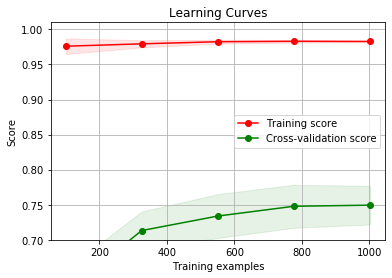

Wall time: 11.8 s


In [27]:
%time cherry.display(model=cherryMod, clf_method='SGD')

In [28]:
分类类别 = "正常 / 违法 / 敏感 / 涩情 / 违和 / 广告".split(" / ")

In [29]:
显示文本分类(示例文本, cherryMod, 0, 分类类别)

句子00`摩擦试的应该更难做吧                                   	`概率 →  98.5%   0.0%   0.2%   1.2%   0.1%   0.0%  (最大概率 → 正常)
句子01`摩擦生电效率和材料有关? 大部分能量都转化为内能了       	`概率 → 100.0%   0.0%   0.0%   0.0%   0.0%   0.0%  (最大概率 → 正常)
句子02`不是只需要传送带传送电荷吗                             	`概率 → 100.0%   0.0%   0.0%   0.0%   0.0%   0.0%  (最大概率 → 正常)
句子03`买个华业通信电源吧                                     	`概率 →  99.8%   0.0%   0.0%   0.0%   0.2%   0.0%  (最大概率 → 正常)
句子04`某位老兄的线圈就是这么死的                             	`概率 →  99.9%   0.0%   0.0%   0.0%   0.1%   0.0%  (最大概率 → 正常)
句子05`GDT本身就是变压器                                      	`概率 →  99.5%   0.0%   0.0%   0.0%   0.4%   0.0%  (最大概率 → 正常)
句子06`最近这么多人加群                                       	`概率 →  97.8%   1.2%   0.1%   0.5%   0.3%   0.0%  (最大概率 → 正常)
句子07`虚拟机怎么让他全屏界面显示                             	`概率 →  97.9%   0.2%   0.2%   1.0%   0.7%   0.0%  (最大概率 → 正常)
句子08`不包邮的话，白送么                                     	`概率 →  96.2%   0.4%   0.0%   0.2%   2.4%   0.7%  (最大概率 → 正常)
句子09`电源

----  
### 操作数据(通过Pandas工具)
以上内容基本就能实现简单的文本预处理了, 预处理数据作为后级的输入  
**目前主要的目标还是从QQ群聊天记录里提取语料和数据集**  

----

目前(05 Jan. 2020)的想法: 维护一个数据库用以处理和记录对话上下文关系以及前级(文本预处理等)的结果和处理情况

In [30]:
import sqlite3 as sqlite

In [31]:
%time import numpy as np, pandas as pd # 主要是为了简化原始数据的读取和预处理
pd.set_option('max_colwidth',100); pd.set_option('display.max_rows', 20); pd.set_option('display.max_columns', 8) # 为了方便查看内容

Wall time: 575 ms


>  pandas是一款数据处理工具，集成了numpy以及matplotlib，拥有便捷的数据处理以及文件读取能力  

pandas主要有几大功能:  
1. Object Creation: pandas有三种对象, series、df和Panel Object. Series, 通过传入list对象来新建, 可以指定索引; DataFrame, 通过传入numpy数组/dictionary对象来创建.
2. Viewing Data: 查看头部/查看索引和列名/查看统计结果什么的, 还可以转换成numpy格式/做矩阵转置以及排序.
3. Selection: 类似于sql的select, 可以指定列/行/标签/值/位置/条件来筛选
4. Missing Data: 默认的空值是np.nan, 可通过reindex函数来增删改查某坐标轴(行或列)的索引，并返回一个数据的拷贝, 还可以判断是否为空值(返回False或True)
5. Operations: 一些常用计算, 包括平均值/ 数值移动等. (通过应用还可以做累计求和和其他自定义的方法)
6. Merge: pandas提供了多个方法来合并不同的对象. 其中Merge方法类似SQL的合并方式.
7. Grouping: 分组主要是为了对某些数据的计算, 例如df.groupby('A').sum()
8. Reshaping
9. Time Series: pandas很适合用来处理时序, 可以调整时间间隔/时区转换/时间格式转换
10. [Categoricals](http://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html#categorical)
11. Plotting: 用于数据绘图, 和Matplotlib基本一样
12. Getting Data In/Out : 可以方便地在不同类型的文件(csv/text/json/html/excel/sql等)中导入或导出数据

完整的[user guide](https://pandas.pydata.org/pandas-docs/stable/user_guide/)可以在pydata上看到  
*这里主要是要用pandas的DataFrame简化sql操作*  
用 pandas DataFrame 读取数据结果的好处主要是不需要每次都调用 fetchall之类的函数, 还能能方便地通过表头的名字来阅读整个表

In [32]:
Conn_CQ = sqlite.connect("eventv2.db")
# 出于尊重隐私考虑, 不提供这个数据库, 并且这两个数据库相关的部分内容打了码

In [33]:
%%time
query_selectLog = "SELECT `id`, `group`, `account`, `content`, datetime(`time`,'unixepoch','localtime') FROM `event` WHERE `type` = 2 AND `group` != 'qq/group/962****' ORDER by `id` DESC;"
DF_CQdata = pd.read_sql_query(query_selectLog, Conn_CQ)
print("debug --- 对象`DF_CQdata`占用内存 → %0.3fMB" % (sys.getsizeof(DF_CQdata) * 1e-6)  )

debug --- 对象`DF_CQdata`占用内存 → 743.058MB
Wall time: 32.5 s


In [34]:
DF_CQdata

,id,group,account,content,"datetime(`time`,'unixepoch','localtime')"
0,2137829,qq/group/708****08,qq/user/374****91,这里,2020-04-22 17:07:47
1,2137828,qq/group/708****08,qq/user/983****77,这里没有,2020-04-22 17:07:45
2,2137827,qq/group/708****08,qq/user/983****77,没有,2020-04-22 17:07:43
3,2137826,qq/group/222****74,qq/user/312****968,。,2020-04-22 17:07:38
4,2137825,qq/group/708****08,qq/user/983****77,我去下回来抽卡,2020-04-22 17:07:38
...,...,...,...,...,...
2121080,8,qq/group/569****13,qq/user/320****515,"[CQ:at,id=qq/user/225****533] 板子咋卖",2020-01-01 20:04:51
2121081,7,qq/group/569****13,qq/user/221****140,两层圆形的覆铜之间有一个小电容,2020-01-01 20:04:32
2121082,3,qq/group/569****13,qq/user/152****205,像我这种小功率都内部接地,2020-01-01 20:04:03
2121083,2,qq/group/569****13,qq/user/513****92,"[CQ:at,id=qq/user/142****809] [CQ:at,id=qq/user/142****809] 我就谁便用了啵",2020-01-01 20:03:08


### 汇总实例

In [35]:
%%time
# 数据量较大且处理太慢, 不加指示进度都不知道是不是卡死了... 这种非常费时且不稳定的东西需要加个"断点恢复"
任务量 = len(DF_CQdata); tmp_count = 恢复位置 = tmp_count2 = 0; 指示条 = r"-,\,|,/".split(",")
经过预处理的消息 = {}
过滤条件 = "分类概率[index][0] < 0.4216 and (分类概率[index][1] > 0.908 or 分类概率[index][2] > 0.966 or 分类概率[index][3] > 0.996 or 分类概率[index][4] > 0.997 or 分类概率[index][5] > 0.998)"
import pickle  # 用于管理字典的保存和恢复, 以便下次加载上一个检查点
import os
try:
    文件列表 = os.listdir(r"./__checkPoint__/"); 文件列表.sort(key=lambda x: int(x[8:-5]))  # 如果存在检查点就取时间最近的一个
    存储文件名 = re.search("CQppc.cp(1\d{9}).data", str(文件列表[-1]))
    if len(存储文件名.group(1)) > 9:
        if input("发现检查点, 是否继续上次(%s)的进度? Y/N : " % (time.strftime("%m/%d %H:%M:%S", time.localtime(int(存储文件名.group(1)))))).upper() == "Y": 
            print("-"*15 + " 加载中... " + "-"*15)
            with open(r"./__checkPoint__/" + 存储文件名.group(0), "rb") as chekFile:
                经过预处理的消息 = pickle.load(chekFile)
                恢复位置 = len(经过预处理的消息)
            if 恢复位置 > 0:
                print("-"*3 + " 成功加载%d条记录, 继续处理... " % 恢复位置 + "-"*3)
except:
    pass

print(指示条[0] * 40)

for row in range(恢复位置, 任务量):
    try:  # 为了方便停止时保存进度, 使用 try - ... - except KeyboardInterrupt的方式
        tmp_CQ转换 = CQ记录转换(DF_CQdata.iloc[row][3], 过滤条件=过滤条件)
        if len(tmp_CQ转换["内容"]) > 0:
            tmp_分词标注 = 分词并标注(tmp_CQ转换["内容"])
        else:
            tmp_分词标注 = [[[]], [[]]]
        经过预处理的消息[DF_CQdata.iloc[row][0]] = {'CQCODE':tmp_CQ转换['CQ码'], 'PSEG': tmp_分词标注, 'OTHER':tmp_CQ转换['其他数据']}
        tmp_count += 1
        进度 = ( 1 + (tmp_count + 恢复位置) * 100 ) // 任务量
        if tmp_count % 31 == 0:
            print(f"\r|{(进度 // 5) * '■'}{(20 - 进度 // 5) * '　'}| {进度}% {指示条[tmp_count2 % 4]} (正在处理第{tmp_count + 恢复位置}/{任务量}条记录)", end=" ")
            tmp_count2 += 1
        if tmp_count % 6164 == 0 or tmp_count > 任务量 - 2 :
            print("\r[%s]自动检查点(%d/%d)保存中..." % (time.strftime("%m/%d %H:%M:%S", time.localtime()), tmp_count + 恢复位置, 任务量), end="\t"*5)
            try: 
                os.system("rm -rf ./__checkPoint__")
                os.mkdir("__checkPoint__")
            except:
                pass
            try:
                fileName = "./__checkPoint__/CQppc.cp%d.data" % int(time.time())
                with open(fileName, "wb") as chekFile:
                    pydata = pickle.dumps(经过预处理的消息); chekFile.write(pydata)
                    print("\r自动检查点(%s)保存成功" % fileName, end="\t"*5)
            except Exception as errInfo:
                print("进度保存点失败: ", errInfo)
    except KeyboardInterrupt:
        print("\r\n" + "*"*10 + "接收到Ctrl-C, 停止运行, 保存检查点中... " + "*"*10)
        try: 
            os.mkdir("__checkPoint__")
        except:
            pass
        try:
            fileName = "./__checkPoint__/CQppc.cp%d.data" % int(time.time())
            with open(fileName, "wb") as chekFile:
                pydata = pickle.dumps(经过预处理的消息); chekFile.write(pydata)
                print("检查点保存成功(%s)" % fileName)
        except Exception as errInfo:
            print("保存检查点失败: ", errInfo)
        break
print(f"\r|{(进度 // 5) * '■'}{(20 - 进度 // 5) * '　'}| {进度}% {指示条[tmp_count2 % 4]} (正在处理第{tmp_count + 恢复位置}/{任务量}条记录)", end=" ")

print("\ndebug --- 对象`经过预处理的消息`占用内存 → %0.3fMB" % (sys.getsizeof(经过预处理的消息) * 1e-3))
# TODO: 打算做成分片处理, 以便用多进程加速, 也是方便保存和分批处理

发现检查点, 是否继续上次(04/30 15:44:07)的进度? Y/N :  Y


--------------- 加载中... ---------------
--- 成功加载104788条记录, 继续处理... ---
----------------------------------------
|■■■■■■■■■■■■　　　　　　　　| 60% | (正在处理第1291065/2121085条记录) 											
**********接收到Ctrl-C, 停止运行, 保存检查点中... **********
检查点保存成功(./__checkPoint__/CQppc.cp1588264993.data)
|■■■■■■■■■■■■　　　　　　　　| 60% / (正在处理第1291068/2121085条记录) 
debug --- 对象`经过预处理的消息`占用内存 → 41943.136KB
Wall time: 8h 55min 11s


In [36]:
# 再维护一个数据库用以记录预处理过的内容以及上下文关系
DB_ppced = r"CQevePPC.db"
Conn_ppced = sqlite.connect(DB_ppced)

目前(10 Jan. 2020)的想法是使用两个表: `ppcLog` 和 `contextIndex`, 分别用于记录预处理后的数据和上下文的关系(按群和时间分组, 以便后续提取对话)

In [37]:
# 数据库设计
query_createTable_ppcLog = '''
CREATE TABLE "ppcLog" (
"lid"       INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
"Link"      INTEGER,
"cqCode"    TEXT,
"jiebaCUT"  TEXT,
"jiebaPSEG" TEXT,
"lastModif" NUMERIC NOT NULL DEFAULT CURRENT_TIMESTAMP,
"note"      TEXT,
"extraData" TEXT
);'''
query_createTable_contextIndex = '''
CREATE TABLE "contextIndex" (
"id_conversation"   INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
"GroupFrom"         INTEGER,
"UserFrom"          INTEGER,
"dialogsContent"    TEXT,
"DialogsLink"       INTEGER
"time_sort"         NUMERIC NOT NULL DEFAULT CURRENT_TIMESTAMP,
"note"              TEXT
);'''

In [38]:
# 先检查数据库状态, 如果没有预设的表那就初始化
def DBtest(dbConnHandle, tableNames, checkQuery = []):
    querys_tableCheck = []
    for i in range( len(tableNames) ):
        querys_tableCheck.append("SELECT * FROM `sqlite_master` where type = 'table' and name = '%s';" % tableNames[i])
    DBisOK = False
    OrigSct = ""
    tmp_cont = 0
    cont_table = 0
    cont_unexc = 0
    for query in querys_tableCheck:
        curs = dbConnHandle.execute(query)
        gets = curs.fetchall()
        if len(gets) > 0:
            OrigSct = gets[-1][-1]
            print("数据表`%s`存在. ~ 读到记录:  \n%s " % (tableNames[tmp_cont], OrigSct) )
            cont_table += 1
            if len(checkQuery) == len(tableNames):
                if re.sub(r"[\s;;\'\"]", "", OrigSct) != re.sub(r"[\s;\'\"]", "", checkQuery[tmp_cont]):
                    cont_unexc -= 4
                else:
                    DBisOK += 1
        tmp_cont += 1

    if checkQuery != []:
        if cont_table < 1 :
            print("指定的表不存在")
            DBisOK = False
        if cont_unexc < 0: 
            if cont_table > 0:
                raise SyntaxWarning("数据库检查未通过: 已经存在不同结构的同名表. (有 %d 个表记录与提供的记录不一致)" % (-cont_unexc / 4))
                return cont_unexc
        else:
            if DBisOK == len(tableNames) :
                print("数据库检查通过. %d 个表(共%d个表)校验一致" % (DBisOK, len(tableNames)) )
                DBisOK = True    
    else:
        if DBisOK == len(tableNames) :
            print("指定表存在")
            DBisOK = True
        else:
            print("指定表不存在")
            DBisOK = False
    return DBisOK        

In [39]:
def DB_init(dbConnHandle, tableNames = [], checkQuery = []):
    realyNeedInit = False
    try:
        dbStatus = DBtest(dbConnHandle, tableNames, checkQuery)
    except SyntaxWarning as info:
        print("初始化失败, 建议检查运行环境(文件冲突). 错误信息:  \n    ", info)
        return -233
    if dbStatus == False:
        realyNeedInit = True
    elif dbStatus < 0:
        r
    if realyNeedInit == True:
        print("准备开始初始化...")
        try:
            for query in checkQuery:
                dbConnHandle.execute(query)
            print("提交变动...")
            dbConnHandle.commit()
            print("数据表初始化完成")
        except Exception as errinfo: 
            print("---SQL执行失败---: ", errinfo)
    else:
        print("已存在同名表, 跳过初始化")

In [40]:
%time DB_init(Conn_ppced, ["ppcLog", "contextIndex"], [query_createTable_ppcLog, query_createTable_contextIndex])

数据表`ppcLog`存在. ~ 读到记录:  
CREATE TABLE "ppcLog" (
"lid"       INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
"Link"      INTEGER,
"cqCode"    TEXT,
"jiebaCUT"  TEXT,
"jiebaPSEG" TEXT,
"lastModif" NUMERIC NOT NULL DEFAULT CURRENT_TIMESTAMP,
"note"      TEXT,
"extraData" TEXT
) 
数据表`contextIndex`存在. ~ 读到记录:  
CREATE TABLE "contextIndex" (
"id_conversation"   INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
"GroupFrom"         INTEGER,
"UserFrom"          INTEGER,
"dialogsContent"    TEXT,
"DialogsLink"       INTEGER
"time_sort"         NUMERIC NOT NULL DEFAULT CURRENT_TIMESTAMP,
"note"              TEXT
) 
数据库检查通过. 2 个表(共2个表)校验一致
已存在同名表, 跳过初始化
Wall time: 3 ms


In [41]:
%time DBtest(Conn_ppced, ["ppcLog", "contextIndex"], [query_createTable_ppcLog, query_createTable_contextIndex])

数据表`ppcLog`存在. ~ 读到记录:  
CREATE TABLE "ppcLog" (
"lid"       INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
"Link"      INTEGER,
"cqCode"    TEXT,
"jiebaCUT"  TEXT,
"jiebaPSEG" TEXT,
"lastModif" NUMERIC NOT NULL DEFAULT CURRENT_TIMESTAMP,
"note"      TEXT,
"extraData" TEXT
) 
数据表`contextIndex`存在. ~ 读到记录:  
CREATE TABLE "contextIndex" (
"id_conversation"   INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
"GroupFrom"         INTEGER,
"UserFrom"          INTEGER,
"dialogsContent"    TEXT,
"DialogsLink"       INTEGER
"time_sort"         NUMERIC NOT NULL DEFAULT CURRENT_TIMESTAMP,
"note"              TEXT
) 
数据库检查通过. 2 个表(共2个表)校验一致
Wall time: 2 ms


True

接下来是把预处理好的内容存入数据库, 并标注哪些内容已经处理以及修改时间.  
为了提高插入数据的效率, 使用"executemany". 当然, 还可以用pandas.DataFrame.to_sql, 不过这里就怎么省事怎么来了. 
需要注意的是, 如果想要用sqlite3的python接口"executemany", 传入数据需要是`[(xxx,xx,...,x),...,(x,xxx,...,xx)]`的结构, 其中每个元组的元素数要对应占位符.   
另外, 一次处理的量不能太大(我也不清楚为什么这么说, 不过我实测了一次插入5万条记录也没有异常. 只是尽量避免被坑吧), 所以采用分批处理.   
这里为了方便增加新数据, 还是采用断点.  

In [42]:
%%time
print("查找变化...")

query_selectLog = "SELECT * FROM `ppcLog`;"
DF_PPCdata = pd.read_sql_query(query_selectLog, Conn_ppced)

索引_当前已处理 = list(经过预处理的消息.keys())
已存索引 = DF_PPCdata["Link"] if len(DF_PPCdata["Link"]) > 0 else [max(索引_当前已处理)]
已存最小索引, 已存最大索引 = min(已存索引), max(已存索引)
当前最小编号, 当前最大编号 = min(索引_当前已处理), max(索引_当前已处理)
tmp_buff = []  # 分批插入的buff, 这里以6164条一批为例
添加计数 = 0; bound, cur = 0, 233; 批次 = 1

if 当前最大编号 > 已存最大索引:  # 说明更新了消息记录源, 新的消息被处理. 顺序添加.
    print("发现新增内容, 向上添加...")
    索引_当前已处理.reverse()  # 记录是倒序的, 新增模式用正序方便处理.
    bound, cur = 索引_当前已处理.index(当前最大编号), 索引_当前已处理.index(已存最大索引)
elif (当前最小编号 < 已存最小索引) and (当前最小编号 > 0):  # 说明继续处理了之前没处理完的内容(主要存在于初始化调试阶段)
    print("发现补充内容, 向下添加...")
    bound, cur = 索引_当前已处理.index(当前最小编号) + 1, 索引_当前已处理.index(已存最小索引)
else:  # 说明没有新内容, 跳过
    print("没有更新, 跳过.")

while cur < bound:
    if bound - cur > 6164:
        print("\r正在处理第%d批(%d~%d行)" % (批次, cur, cur+6164), end=" \t "*3)
        tmp_buff = [[key, 经过预处理的消息[key]] for key in 索引_当前已处理[cur:cur+6164]]
        cur += 6164
    else:
        print("\r正在处理第%d批(%d~%d行)" % (批次, cur, bound), end=" \t "*3)
        tmp_buff = tmp_buff = [[key, 经过预处理的消息[key]] for key in 索引_当前已处理[cur:bound]]
        cur = bound
    Conn_ppced.executemany(
            "insert into ppcLog (`Link`, `cqCode`, `jiebaCUT`, `jiebaPSEG`, `note`, `extraData`) values (?, ?, ?, ?, 'initialize', ?)",
            [ ( int(link), str(res['CQCODE']), str(res["PSEG"][0]), str(res["PSEG"][1]), str(res['OTHER']) )  for link, res in tmp_buff ]
        ) 
    添加计数 += len(tmp_buff)
    批次 += 1

print("\n新增了%d条记录, 当前记录范围: %d~%d" % (添加计数, 当前最小编号, 当前最大编号))
Conn_ppced.commit() # 操作后应该尽快提交, 以免数据库锁带来的麻烦(尤其是多线程)

查找变化...
发现补充内容, 向下添加...
正在处理第193批(1289152~1291068行) 	  	  	  	  	  	  	  	 
新增了1185404条记录, 当前记录范围: 837541~2137829
Wall time: 19.2 s


In [43]:
# 提交完了, 瞅瞅情况
query_selectLog = "SELECT * FROM `ppcLog`;"
数据库中的预处理结果 = pd.read_sql_query(query_selectLog, Conn_ppced)

In [44]:
数据库中的预处理结果

,lid,Link,cqCode,jiebaCUT,jiebaPSEG,lastModif,note,extraData
0,1,2137829,[],['[⌳][*unclearContent*]这里'],['[⌳][*unclearContent*]这里'],2020-04-30 07:44:33,initialize,{}
1,2,2137828,[],[['没有']],[['v']],2020-04-30 07:44:33,initialize,{}
2,3,2137827,[],[['没有']],[['v']],2020-04-30 07:44:33,initialize,{}
3,4,2137826,[],['[⌳][*unclearContent*]。'],['[⌳][*unclearContent*]。'],2020-04-30 07:44:33,initialize,{}
4,5,2137825,[],"[['去', '下', '回来', '抽', '卡']]","[['v', 'f', 'v', 'v', 'n']]",2020-04-30 07:44:33,initialize,{}
...,...,...,...,...,...,...,...,...
1291064,1291065,837545,[],"[['直接', '买', '算了']]","[['ad', 'v', 'v']]",2020-04-30 16:43:46,initialize,{}
1291065,1291066,837544,"['[CQ:image,file=81507F2F571DE0BBE5B353A431512E7D.jpg]']","[['ECQ', '码', '转义']]","[['eng', 'n', 'v']]",2020-04-30 16:43:46,initialize,{}
1291066,1291067,837543,[],['[⌳][*unclearContent*]3'],['[⌳][*unclearContent*]3'],2020-04-30 16:43:46,initialize,{}
1291067,1291068,837542,[],"[['要', '猜']]","[['v', 'v']]",2020-04-30 16:43:46,initialize,{}


-----
## 总结
NLP项目通常需要用到词向量模型, 这就需要先把语料库中的句子做分词处理.  
只是对于群聊消息记录这类数据的预处理来说, 还需要一些其他的处理才能筛选出有意义的语句并分词处理. 其中, 非语素却又有必要留着的, 例如URI/表情/分享内容等, 可以通过正则表达式将其筛出单独存放, 可考虑用个自定的占位符或者转义标注来代替被过滤掉的内容; 不和谐、违法违规的内容应该直接过滤以避免不必要的麻烦; 不同语系的处理差异较大, 非主体语言的句子最好单独分出来单独处理.  

以上内容便实现了数据接口以及数据预处理的基础功能(所以作为第0部分), 接下来开始真正的NLP内容  

------

本文内容仅为个人见解和心得, 希望能带来帮助. 如果有不正确/不准确之处还请多多指教, 一起学习一起进步~   

本文内容由[佚之狗](https://github.com/HookeLiu)原创, 可以随意使用但请注明出处.    

如果希望这样的文章能更多更好的话, 那就不妨给打赏点吧~  
<div style="margin:0 auto;">
    <img  src="https://common-10064274.cos.ap-shanghai.myqcloud.com/ui/beg_QR.min.png" alt="打发点呗~" weight="42%" />
</div>
